## Brain Hemorrhage Detection

### Load libraries

In [1]:
# Checking GPU availability
from __future__ import absolute_import, division, print_function, unicode_literals #to check for gpu

# %load_ext autoreload
# %autoreload 2

# Custom libraries
from custom_libraries import file_saving
from custom_libraries import image_processing
from custom_libraries import import_data
from custom_libraries import model_support

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Images
import pydicom
import cv2

# Batching for DataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence

# Keras, Tensorflow and other model related
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Checking devices and system settings
import sys
print("Python: ", sys.version[:6])
print("Keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)
print("GPU Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nAll devices:", *tf.config.experimental.list_physical_devices(),sep="\n")
gpu_count = len(tf.config.experimental.list_physical_devices('GPU'))

# saving to cloud storage
from google.cloud import storage
from custom_libraries import gcloud_storage


Using TensorFlow backend.


Python:  3.5.3 
Keras:  2.3.0
Tensorflow:  2.0.0
GPU Available:  True
Num GPUs Available:  1

All devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Set global variables
batch_size=128
dim=(512,512)
data_path = "../data/"   # used when calling DataGenerator
random_seed = 12345


## Import Data and Create Data Generator

In [3]:
# get df of image paths and labels
image_list = import_data.clean_data_csv(shuffle_data = True)

# remove images of different sizes (~200 images)
image_list = image_list[~image_list.filename.isin([x+'.dcm' for x in import_data.corrupted_images()])]

# create a df of images to use for analysis
data = import_data.balanced_images_binary(image_list)

# split train and validation data
train_data, valid_data = train_test_split(data, test_size = 0.15, random_state = random_seed)

In [4]:
# limit datasets to a multiple of batch_size
train_data_excess = len(train_data) % batch_size
valid_data_excess = len(valid_data) % batch_size

train_data = train_data[:-train_data_excess]
valid_data = valid_data[:-valid_data_excess]

In [5]:
traingen=image_processing.DataGenerator_single_class(train_data,data_path = data_path, batch_size = batch_size)
validgen=image_processing.DataGenerator_single_class(valid_data,data_path = data_path, batch_size = batch_size)

In [6]:
train_data_test = train_data[0:batch_size*5]
valid_data_test = valid_data[0:batch_size*1]

traingen_test=image_processing.DataGenerator_single_class(train_data_test,data_path = data_path, batch_size = batch_size)
validgen_test=image_processing.DataGenerator_single_class(valid_data_test,data_path = data_path, batch_size = batch_size)

In [7]:
train_data.info()
# valid_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164864 entries, 77465 to 3511
Data columns (total 7 columns):
filename            164864 non-null object
any                 164864 non-null int64
epidural            164864 non-null int64
intraparenchymal    164864 non-null int64
intraventricular    164864 non-null int64
subarachnoid        164864 non-null int64
subdural            164864 non-null int64
dtypes: int64(6), object(1)
memory usage: 10.1+ MB


## Run Model

### Option to Load Model

In [ ]:
# option to load latest model
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
loaded_model = file_saving.load_model(records_output = False, model_output = True, model_file_path = last_record)
model = loaded_model

### Model Notes and Parameters

In [29]:
# Add weighted log loss - https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model
# model_notes = "model_2, with dropout, 165k images, balanced across any and none, binary, 512"
model_notes = "model 1 starting ~90 valid acc; continuing 165k train images, balanced acrossany and none, binary, 512"
model_tags = ['binary', 'img_size:512', 'model_1']

epochs = 2
loss='binary_crossentropy'
optimizer='adam'

In [ ]:
# model_notes = "test, binary, 512"
# model_tags = ['binary', 'img_size:512', 'test']

### Model 1

In [ ]:
def model_1():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5,5)))

    model.add(Flatten())  

    # model.add(Dense(100))
    # model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))

    # for 6 classes
    model.add(Dense(6, activation = 'sigmoid'))

    # for 1 class
    model.add(Dense(1, activation = 'sigmoid'))

    return model
model = model_1()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


### Model 2

In [12]:
def model_2():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5,5)))

    model.add(Flatten())  

    # model.add(Dense(100))
    # model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

#     # for 6 classes
#     model.add(Dense(6, activation = 'sigmoid'))

    # for 1 class
    model.add(Dense(1, activation = 'sigmoid'))

    return model
model = model_2()
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


### Train Selected Model

In [ ]:
# run model

history=model.fit_generator(
    generator=traingen,
    validation_data=validgen,
    use_multiprocessing=True,
    workers=11,
    epochs=epochs)

file_saving.save_model(
    model, 
    return_df=True, 
    model_notes=model_notes,
    loss = loss,
    optimizer = optimizer,
    dim = dim[0],
    epochs = epochs,
    train_size = len(train_data),
    validation_size = len(valid_data)
).tail(3)

Epoch 1/2
  84/1288 [>.............................] - ETA: 30:03 - loss: 0.1476 - accuracy: 0.9364

## Visualize Model Effectiveness

In [34]:
y_pred = model.predict_generator(generator=validgen,use_multiprocessing=True)

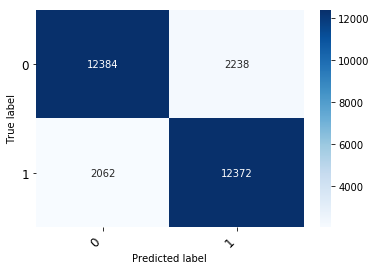

In [35]:
model_support.get_confusion_matrix(valid_data['any'],y_pred)
plt.savefig('models/latest_confusion_matrix.png')

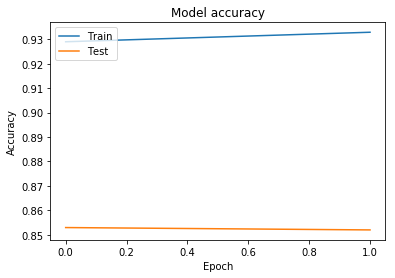

In [36]:
# plot accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_accuracy.png')
plt.show()


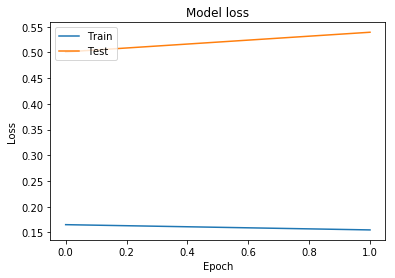

In [74]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('models/latest_model_loss.png')
plt.show()

## Plot cost curve

In [ ]:
# to be added later
def get_cost(cm,costs)
    """Outputs the cost given a cm and costs for each quadrant
    Key Arguments:
    cm: confusion matrix
    costs: np.array of costs of each of tp,tn,fp,fn
    """
    pass

threshold_list = np.array([1,2,3])
cost_curve = [
    get_cost(threshhold)
    for threshold
    in threshold_list
]
cost_curve
#plot this cost curve

## Loading Previous Models

In [82]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
activation_3 (Activation)    (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
activation_4 (Activation)    (None, 253, 253, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)            

In [42]:
# See df of most recent records
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]

# load_model last model
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = last_record)

records.tail(10)

epochs layers                  model_name  \
20       1     []  2019-10-19T074255_model.h5   
21       1     []  2019-10-21T012256_model.h5   
22       1     []  2019-10-21T012507_model.h5   
23       1     []  2019-10-21T013017_model.h5   
24       1     []  2019-10-21T013140_model.h5   
25       1     []  2019-10-21T033555_model.h5   
26       1     []  2019-10-21T051800_model.h5   
27       1     []  2019-10-24T044518_model.h5   
28      15     []  2019-10-24T135911_model.h5   
29       2     []  2019-10-24T154029_model.h5   

                                          model_notes  \
20                                  test, binary, 512   
21                                  test, binary, 512   
22                                  test, binary, 512   
23                                  test, binary, 512   
24                                  test, binary, 512   
25  165k train images, balanced across any and non...   
26  165k train images, balanced across any and non...   
27  continuing 165k train images, balanced across ...   
28  model_2, with dropout, 165k images, balanced a...   
29  model 1 starting ~90 valid acc; continuing 165...   

                           model_path               model_tags  num_layers  \
20  models/2019-10-19T074255_model.h5  {'keras', 'tensorflow'}           0   
21  models/2019-10-21T012256_model.h5  {'keras', 'tensorflow'}           0   
22  models/2019-10-21T012507_model.h5  {'keras', 'tensorflow'}           0   
23  models/2019-10-21T013017_model.h5  {'keras', 'tensorflow'}           0   
24  models/2019-10-21T013140_model.h5  {'keras', 'tensorflow'}           0   
25  models/2019-10-21T033555_model.h5  {'keras', 'tensorflow'}           0   
26  models/2019-10-21T051800_model.h5  {'keras', 'tensorflow'}           0   
27  models/2019-10-24T044518_model.h5  {'keras', 'tensorflow'}           0   
28  models/2019-10-24T135911_model.h5  {'keras', 'tensorflow'}           0   
29  models/2019-10-24T154029_model.h5  {'keras', 'tensorflow'}           0   

   optimizer  score                   timestamp  train_size  validation_size  \
20         1      1  2019-10-19 07:42:55.813587           1                1   
21         1      1  2019-10-21 01:22:56.730828           1                1   
22         1      1  2019-10-21 01:25:07.216196           1                1   
23         1      1  2019-10-21 01:30:17.505741           1                1   
24         1      1  2019-10-21 01:31:40.354051           1                1   
25         1      1  2019-10-21 03:35:55.310261           1                1   
26         1      1  2019-10-21 05:18:00.485887           1                1   
27      adam      1  2019-10-24 04:45:18.152352      164864            29056   
28      adam      1  2019-10-24 13:59:11.733776      164864            29056   
29      adam      1  2019-10-24 15:40:29.681138      164864            29056   

      dim  
20    NaN  
21    NaN  
22    NaN  
23    NaN  
24    NaN  
25    NaN  
26    NaN  
27  512.0  
28  512.0  
29  512.0

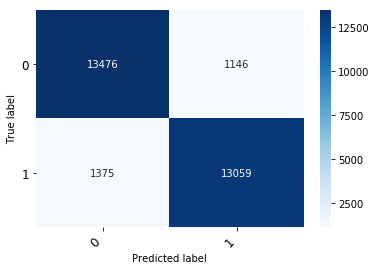

In [45]:
# load best model
best_record = 'models/2019-10-24T044518_model.h5'
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = best_record)
y_pred = loaded_model.predict_generator(generator=validgen,use_multiprocessing=True)
model_support.get_confusion_matrix(valid_data['any'],y_pred)
# plt.savefig('models/{}_confusion.png'.format(best_record.split('/')[1].split('.')[0])) # does not have access to img

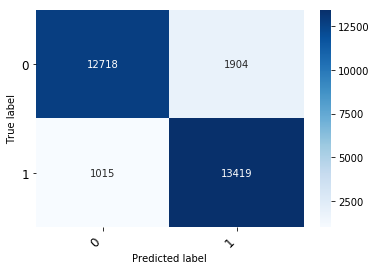

In [46]:
# load another good model
best_record = 'models/2019-10-21T051800_model.h5'
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = best_record)
y_pred = loaded_model.predict_generator(generator=validgen,use_multiprocessing=True)
model_support.get_confusion_matrix(valid_data['any'],y_pred)
# plt.savefig('models/{}_confusion.png'.format(best_record.split('/')[1].split('.')[0])) # does not have access to img

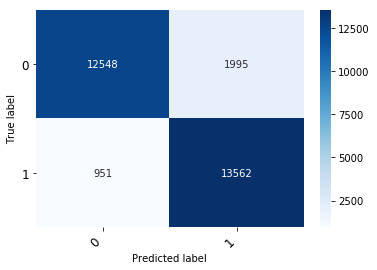

In [44]:
# load_model last model
records = file_saving.load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
_, loaded_model = file_saving.load_model(records_output = True, model_output = True, model_file_path = last_record)
y_pred = loaded_model.predict_generator(generator=validgen,use_multiprocessing=True)
model_support.get_confusion_matrix(valid_data['any'],y_pred)
# plt.savefig('models/{}_confusion.png'.format(last_record.split('/')[1].split('.')[0])) # does not have access to img

## (Optional) Visualizing a batch of images

In [68]:
labels = list(image_list.columns)[1:]

images_any = image_list[image_list['any']==1]
images_none = image_list[image_list['any']==0]
images_epidural = image_list[image_list['epidural']==1]
images_intraparenchymal = image_list[image_list['intraparenchymal']==1]
images_intraventricular = image_list[image_list['intraventricular']==1]
images_subarachnoid = image_list[image_list['subarachnoid']==1]
images_subdural = image_list[image_list['subdural']==1]

['../data/stage_1_train_images/ID_51a1531aa.dcm',
 '../data/stage_1_train_images/ID_5daf91e0b.dcm',
 '../data/stage_1_train_images/ID_a6933d6ca.dcm',
 '../data/stage_1_train_images/ID_ce3045a92.dcm',
 '../data/stage_1_train_images/ID_58762e8f0.dcm',
 '../data/stage_1_train_images/ID_a2b5b8f19.dcm',
 '../data/stage_1_train_images/ID_87e7c02e0.dcm',
 '../data/stage_1_train_images/ID_308e3b617.dcm',
 '../data/stage_1_train_images/ID_f47f74066.dcm',
 '../data/stage_1_train_images/ID_e3819cf69.dcm',
 '../data/stage_1_train_images/ID_6727fe9ec.dcm',
 '../data/stage_1_train_images/ID_1a79e5c1e.dcm',
 '../data/stage_1_train_images/ID_af64f7634.dcm',
 '../data/stage_1_train_images/ID_321eccb6d.dcm',
 '../data/stage_1_train_images/ID_72c9573a7.dcm',
 '../data/stage_1_train_images/ID_b350da2cb.dcm',
 '../data/stage_1_train_images/ID_54e91565d.dcm',
 '../data/stage_1_train_images/ID_66c961c0f.dcm',
 '../data/stage_1_train_images/ID_dfbd109f1.dcm',
 '../data/stage_1_train_images/ID_8daf27e11.dcm',


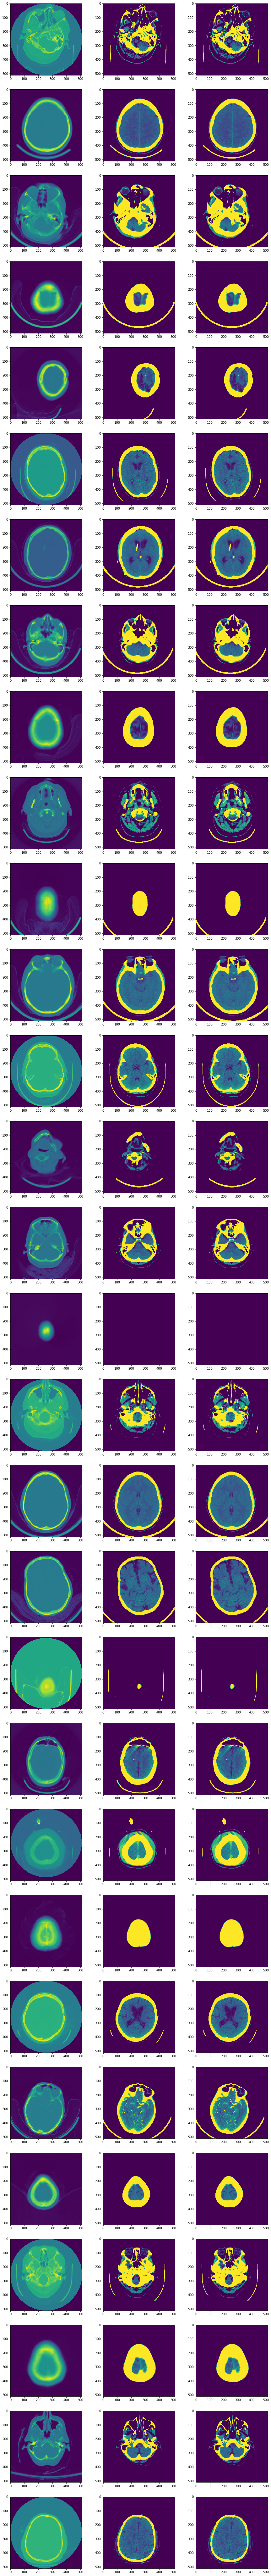

In [73]:
image_paths = ['../data/stage_1_train_images/'+filename for filename in images_none[:30].filename]
image_processing.display_image_processing(image_paths = image_paths,bone_color=False)

none
epidural
intraparenchymal
intraventricular
subarachnoid
subdural


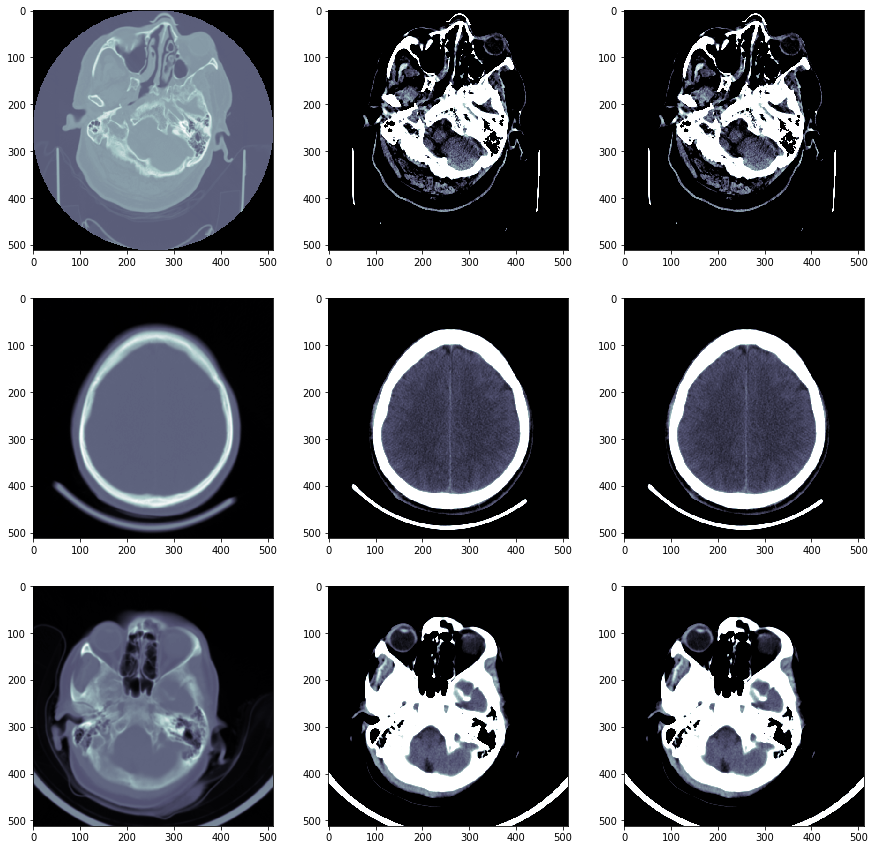

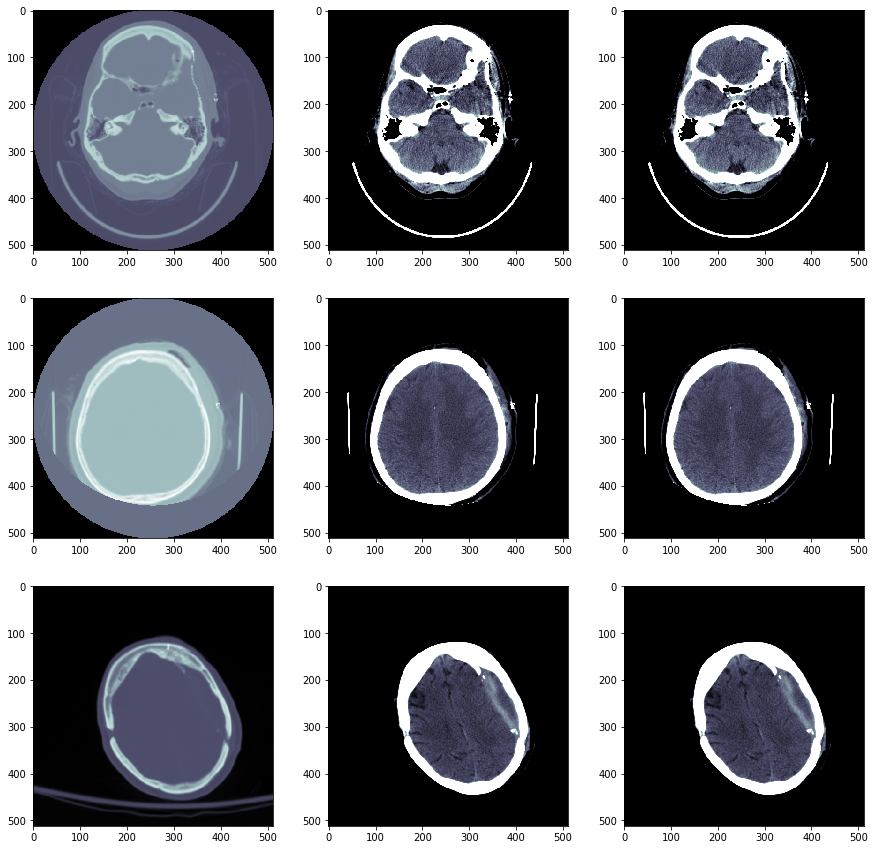

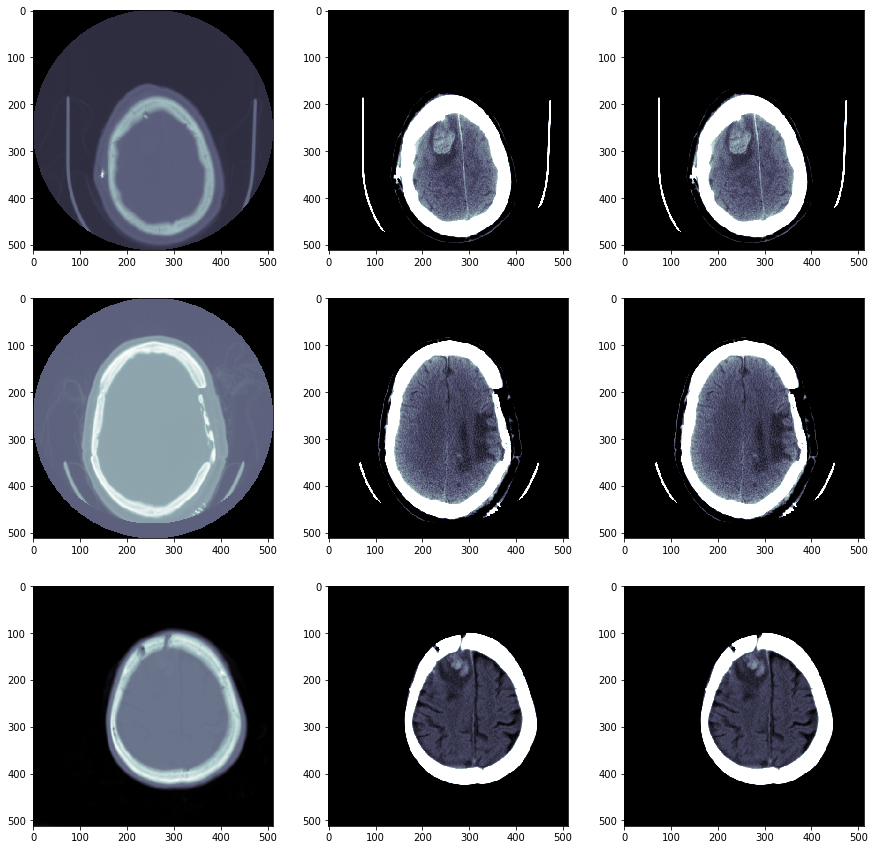

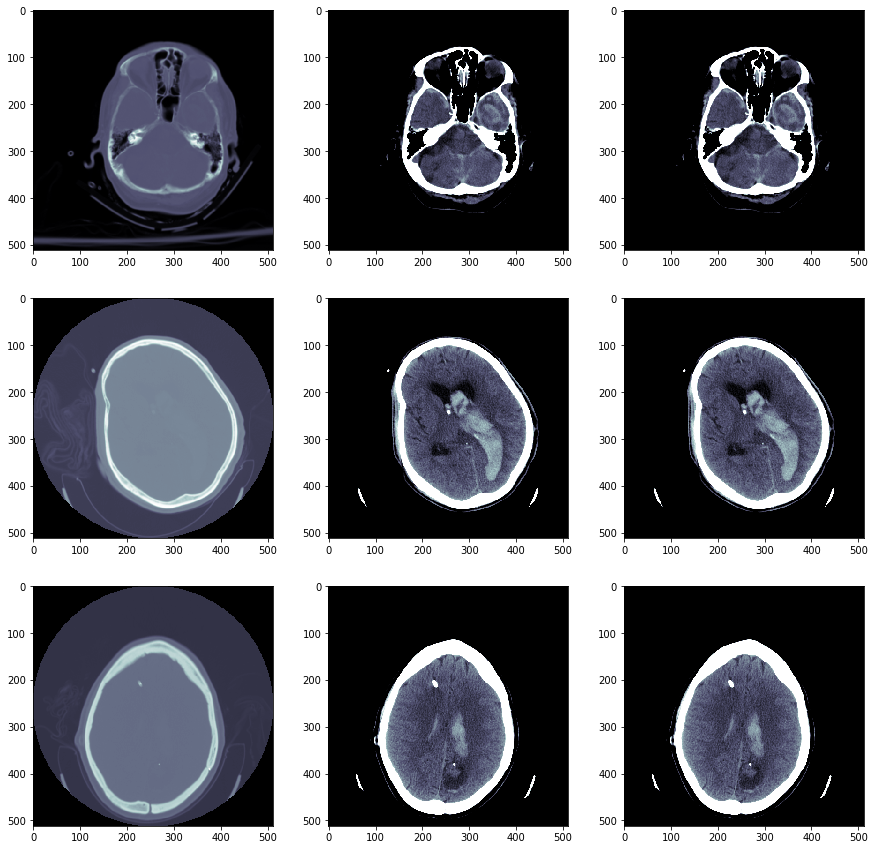

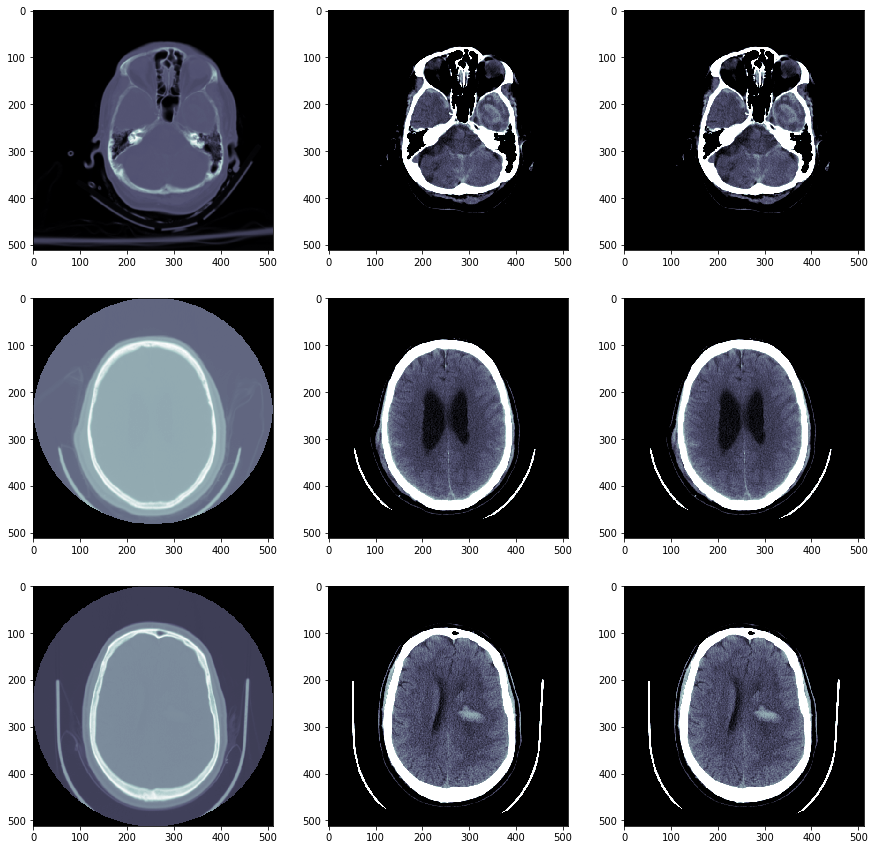

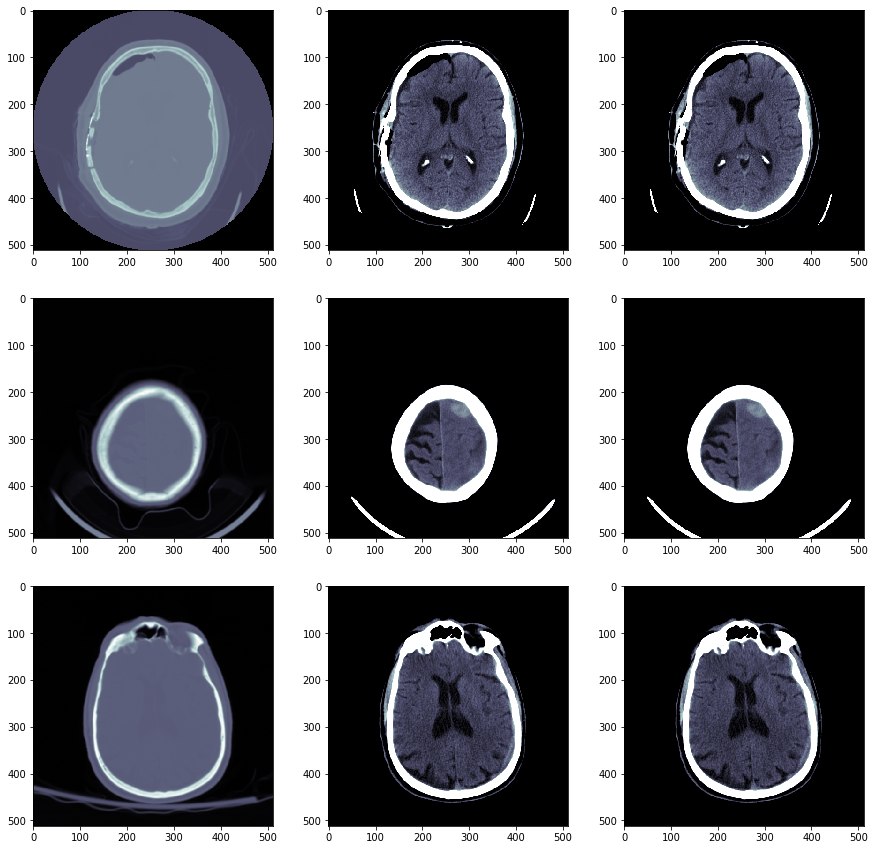

In [71]:
starting_image = 0
n_images = 3 # number of images of each class to show
ending_image = starting_image + n_images
labels = ['none','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
for i, class_of_images in enumerate([images_none,images_epidural, images_intraparenchymal, images_intraventricular, images_subarachnoid, images_subdural]):
    print(labels[i])
    image_paths = ['../data/stage_1_train_images/'+filename for filename in class_of_images[starting_image:ending_image].filename]
    image_processing.display_image_processing(image_paths = image_paths)

In [ ]:
# visualize a batch of images
batch = 27
batch_of_images = image_list[batch_size*np.min(batch-1,0):batch_size*batch]
image_paths = ['../data/stage_1_train_images/'+filename for filename in batch_of_images.filename]
image_processing.display_image_processing(image_paths = image_paths)